In [1]:
#change in weights over training. This is buggy.....

import torch
import sys
import os
import io
from os.path import exists
import numpy as np
import pickle
import ipywidgets as widgets 
from scipy.special import softmax
import glob

import gzip, pickle, pickletools


from sklearn.linear_model import LinearRegression
from scipy.stats import ranksums, wilcoxon
import statsmodels.api as sm


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.stats import ranksums, wilcoxon

from dynamics.utils import utils
from dynamics.vis import dynamics as dyplot


from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_reinforce, wt_costs, wt_reinforce_cont_new, wt_pred, parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.utils.utils import CPU_Unpickler,parse_configs, displ, memcheck, opsbase, mwa
from dynamics.analysis import state_analysis as sta

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import interpolate
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib widget 
#out = widgets.Output(layout = widgets.Layout(height='300px'))

In [2]:
#path info

#subdirlist = ['full_cl/','pkind_mem/','pkind_count/', 'pkind_int/', 'pkind_pred/']
#subdirlist = ['full_cl/','pkind_min_int/', 'nok_cl/','nok_nocl/']
subdirlist = ['full_cl/', 'nok_cl/','nok_nocl/', 'full_cl_redo/']
s_idx = 0

#something about the auxiliary losses is different in this form compared to the 0206 form. find it. I think
# that it is the reward rate being added back into the loss 

#savedir = '/scratch/dh148/dynamics/results/rnn/ac/20230113_clstudy_mr2/'+subdirlist[s_idx]+'figs/'
#dbase = '/scratch/dh148/dynamics/results/rnn/ac/20230113_clstudy_mr2/'
#datadir_dat = lambda s_idx: dbase+subdirlist[s_idx]
#configdir = lambda s_idx: '/home/dh148/projects/dynamics/jobs/20230113_clstudy_mr2/rnn/'+subdirlist[s_idx]

#the real dir
savedir = '/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/'+subdirlist[s_idx]+'figs/'
dbase = '/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/'
datadir_dat = lambda s_idx: dbase+subdirlist[s_idx]
configdir = lambda s_idx: '/home/dh148/projects/dynamics/jobs/20230206_clstudy/rnn/'+subdirlist[s_idx]

configname_fun = lambda num, s_idx: configdir(s_idx) +str(num)+'.cfg'

#some basics
nhidden = 512


In [3]:
#decide which networks to pull, and order their names

fgen = lambda num,idx, base, sess, s_idx : datadir_dat(s_idx)+str(num)+'/'+base + str(num)+'_'+sess+'_'+str(idx)


fname_funs = [lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_simple',
              lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_int_0_'+str(idx),
              lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_pred_' + str(num)+'_'+str(idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'nocatch', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'catch', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx)+'_freeze'
             ]

#check these learning rates
lr_task = 0.0001
lr_kind = 0.0001
lr_pred = 0.001
base_epoch_kind = 1000
base_epcoh_pred = 10
base_epoch_task = 1000

r_task = base_epoch_task*lr_task
r_kind = base_epoch_kind*lr_kind
r_pred = base_epcoh_pred*lr_pred

n_int = int(r_task/r_kind) # grab model every 500 saves. did once per epoch
n_pred = int(r_task/r_pred)
print(n_pred)


10


In [4]:
[n_int,n_pred]

[1, 10]

In [29]:
#output weights across training

#needops

def weight_outpt_acrosstraining(s_idx = 0, num = 0,n_int = 1, n_pred = 1):
    """
    gets the output projection across an entire set of training. does not include kindergarten 
    s_idx: CL type 0:full, 1:nok_cl, 2: nok_nocl, others are pkind?
    num: RNN number
    """
    
    device = torch.device('cpu')
    modeltype = 'RNNModel_multiregion_2allt'
    
    stagelist = []
    idxlist = []
    
    #lin sensitivity, wt ratio, historical regression, opt out, violation

    w_pred = []
    w_policy = []
    w_val = []
    w_rr =[]
    w_mem = []
    w_time = []
    w_str_rnn = []
    w_ofc_rnn = []
    w_str_inp = []
    w_ofc_inp = []
    
    fname_fun_stage = lambda stage, idx: fname_funs[stage](num, idx, s_idx)
    
    
    #find max int and pred in the directory
    nmax_int = 5000
    nmax_pred = 150
    
    #nmax_int = len(glob.glob(datadir_dat(s_idx)+str(num)+'/rnn_kindergarten_'+str(num)+'_int*.model'))
    #nmax_pred = len(glob.glob(datadir_dat(s_idx)+str(num)+'/rnn_pred_'+str(num)+'*.model'))
    
  
    idxranges = [range(1,2), range(1,nmax_int+1, n_int), range(1,nmax_pred+1, n_pred), 
                 range(1,11), range(1,11), range(1,61)]
    #idx of networks to pull for each portion of training

       
    
    #add in theinitialc ondition
    nd = wt_nets.netdict[modeltype]  # dictionary of models and size params
    netfun = nd['net']  
    netseed = num
    net = netfun(din=nd['din'], dout=nd['dout'], num_hiddens=[256,256], seed=netseed, rnntype='LSTM',
                 bias_init=0)
    
    stagelist.append(-1)
    idxlist.append(0)
    
    w_ofc = net.linear1.weight.detach().numpy()
    w_str = net.linear2.weight.detach().numpy()
    w_pred.append(w_ofc[0:3,:]) #predition
    w_policy.append(w_str[0:3,:]) #policies
    w_val.append(w_str[3,:])
    w_mem.append(w_str[4,:])
    w_time.append(w_str[5,:])
    w_rr.append(w_ofc[3,:])
    w_ofc_rnn.append(net.rnn1.weight_hh_l0.detach().numpy())
    w_str_rnn.append(net.rnn2.weight_hh_l0.detach().numpy())
    w_ofc_inp.append(net.rnn1.weight_ih_l0.detach().numpy())
    w_str_inp.append(net.rnn2.weight_ih_l0.detach().numpy())
    
    
    for stage in range(6):
    #for stage in [4,5,6]:
    
        for idx in idxranges[stage]:
            
            #assume what is needed is in the stats. if not, do .dat files
            fname_model = fname_fun_stage(stage, idx)+ '.model'

            
            if exists(fname_model):
                
                stagelist.append(stage)
                idxlist.append(idx)
                
                #load the model
                
                nd = wt_nets.netdict[modeltype]  # dictionary of models and size params
                netfun = nd['net']  
                netseed = num
                net = netfun(din=nd['din'], dout=nd['dout'], num_hiddens=[256,256], seed=netseed, rnntype='LSTM',
                             bias_init=0)

                net.load_state_dict(torch.load(fname_model, map_location=device.type))
                
                w_ofc = net.linear1.weight.detach().numpy()
                w_str = net.linear2.weight.detach().numpy()
                w_pred.append(w_ofc[0:3,:]) #predition
                w_policy.append(w_str[0:3,:]) #policies
                w_val.append(w_str[3,:])
                w_mem.append(w_str[4,:])
                w_time.append(w_str[5,:])
                w_rr.append(w_ofc[3,:])
                w_ofc_rnn.append(net.rnn1.weight_hh_l0.detach().numpy())
                w_str_rnn.append(net.rnn2.weight_hh_l0.detach().numpy())
                w_ofc_inp.append(net.rnn1.weight_ih_l0.detach().numpy())
                w_str_inp.append(net.rnn2.weight_ih_l0.detach().numpy())


                        

                    
    d = {'w_pred':w_pred ,
    'w_mem':w_mem ,
    'w_time':w_time,
    'w_policy':w_policy ,
    'w_val':w_val ,
    'w_rr':w_rr,
    'w_ofc_rnn':w_ofc_rnn,
    'w_str_rnn':w_str_rnn,
    'w_ofc_inp':w_ofc_inp,
    'w_str_inp':w_str_inp}

                
    return d, stagelist, idxlist
                


In [30]:
nnum = 3
d, stagelist, idxlist = weight_outpt_acrosstraining(num = nnum, s_idx = 3, n_int = n_int, n_pred = n_pred)
d['w_ofc_rnn'][1].shape

(1024, 256)

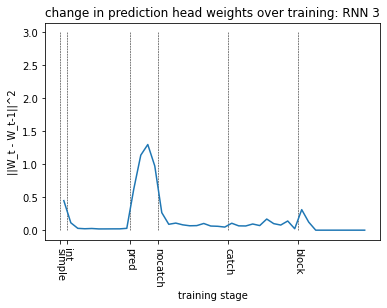

[-1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


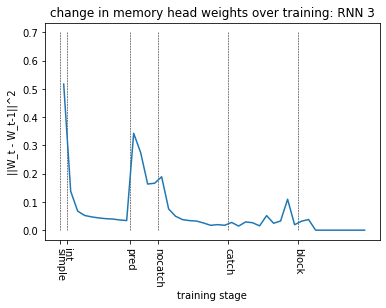

[-1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


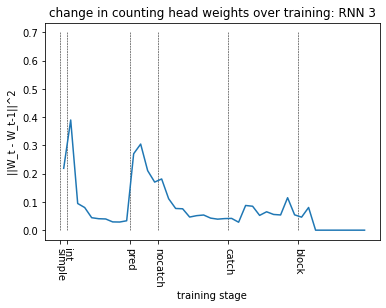

[-1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


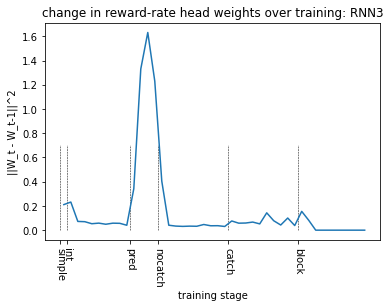

In [31]:




stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block', -1:'init'}
typediff = np.argwhere(np.diff(stagelist)> 0)[:,0]

npred = len(d['w_pred'])
preddiff= np.array([np.linalg.norm(d['w_pred'][k]-d['w_pred'][k-1]) for k in range(1,npred)])
[plt.vlines(k-0.5,  0, 3, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typediff]
plt.xticks(typediff-0.5, labels = [stagedict[stagelist[k+1]] for k in typediff], rotation = -90)
plt.plot(preddiff)
plt.title('change in prediction head weights over training: RNN '+str(nnum))
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
plt.show()




npred = len(d['w_mem'])
preddiff= np.array([np.linalg.norm(d['w_mem'][k]-d['w_mem'][k-1]) for k in range(1,npred)])
[plt.vlines(k-0.5,  0, 0.7, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typediff]
plt.xticks(typediff-0.5, labels = [stagedict[stagelist[k+1]] for k in typediff], rotation = -90)
plt.plot(preddiff)
plt.title('change in memory head weights over training: RNN '+str(nnum))
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
print(stagelist)
plt.show()


npred = len(d['w_time'])
preddiff= np.array([np.linalg.norm(d['w_time'][k]-d['w_time'][k-1]) for k in range(1,npred)])
[plt.vlines(k-0.5,  0, 0.7, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typediff]
plt.xticks(typediff-0.5, labels = [stagedict[stagelist[k+1]] for k in typediff], rotation = -90)
plt.plot(preddiff)
plt.title('change in counting head weights over training: RNN '+str(nnum))
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
print(stagelist)
plt.show()


npred = len(d['w_rr'])
preddiff= np.array([np.linalg.norm(d['w_rr'][k]-d['w_rr'][k-1]) for k in range(1,npred)])
[plt.vlines(k-0.5,  0, 0.7, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typediff]
plt.xticks(typediff-0.5, labels = [stagedict[stagelist[k+1]] for k in typediff], rotation = -90)
plt.plot(preddiff)
plt.title('change in reward-rate head weights over training: RNN'+str(nnum))
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
print(stagelist)
plt.show()


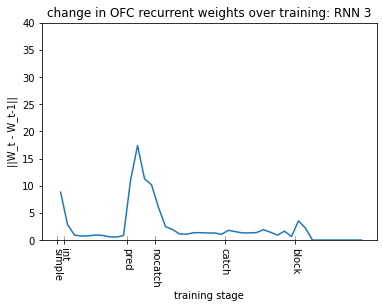

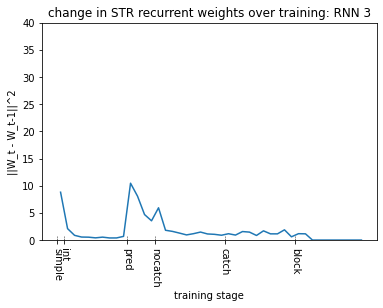

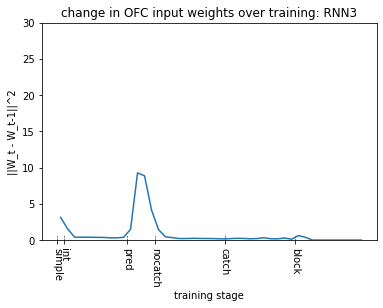

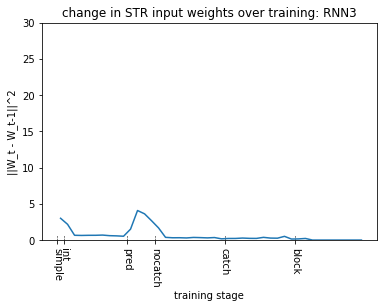

In [32]:

#recurrent RNN weights


stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
typediff = np.argwhere(np.diff(stagelist)> 0)[:,0]



npred = len(d['w_ofc_rnn'])
preddiff= np.array([np.linalg.norm(d['w_ofc_rnn'][k]-d['w_ofc_rnn'][k-1]) for k in range(1,npred)])
[plt.vlines(k-0.5,  0, 0.7, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typediff]
plt.xticks(typediff-0.5, labels = [stagedict[stagelist[k+1]] for k in typediff], rotation = -90)
plt.plot(preddiff)
plt.title('change in OFC recurrent weights over training: RNN '+str(nnum))
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||')
plt.ylim([0,40])
plt.show()


npred = len(d['w_str_rnn'])
preddiff= np.array([np.linalg.norm(d['w_str_rnn'][k]-d['w_str_rnn'][k-1]) for k in range(1,npred)])
[plt.vlines(k-0.5,  0, 0.7, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typediff]
plt.xticks(typediff-0.5, labels = [stagedict[stagelist[k+1]] for k in typediff], rotation = -90)
plt.plot(preddiff)
plt.title('change in STR recurrent weights over training: RNN '+str(nnum))
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
plt.ylim([0,40])
plt.show()


npred = len(d['w_ofc_inp'])
preddiff= np.array([np.linalg.norm(d['w_ofc_inp'][k]-d['w_ofc_inp'][k-1]) for k in range(1,npred)])
[plt.vlines(k-0.5,  0, 0.7, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typediff]
plt.xticks(typediff-0.5, labels = [stagedict[stagelist[k+1]] for k in typediff], rotation = -90)
plt.plot(preddiff)
plt.title('change in OFC input weights over training: RNN'+str(nnum))
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
plt.ylim([0,30])
plt.show()

npred = len(d['w_str_inp'])
preddiff= np.array([np.linalg.norm(d['w_str_inp'][k]-d['w_str_inp'][k-1]) for k in range(1,npred)])
[plt.vlines(k-0.5,  0, 0.7, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typediff]
plt.xticks(typediff-0.5, labels = [stagedict[stagelist[k+1]] for k in typediff], rotation = -90)
plt.plot(preddiff)
plt.title('change in STR input weights over training: RNN'+str(nnum))
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
plt.ylim([0,30])
plt.show()


In [33]:
#do over whole population

def acrossdat_weightchange(s_idx):
    print(s_idx)

    lenlist = []
    predlist_ofc = []
    predlist_str = []
    stagelist_list= []
    
    #max samples for each stage  
    nm = [1, 9, 10, 10, 10, 60]
    nn = 20
    
    predmats_ofc = [np.nan*np.ones((nn,k)) for k in nm]
    predmats_str = [np.nan*np.ones((nn,k)) for k in nm]
    
    #predmat_str_simple = np.nan*np.ones(nn,nm[0])
    #predmat_str_int = np.nan*np.ones(nn,nm[1])
    #predmat_str_pred = np.nan*np.ones(nn,nm[2])
    #predmat_str_nocatch = np.nan*np.ones(nn,nm[3])
    #predmat_str_catch = np.nan*np.ones(nn,nm[4])
    #predmat_str_block = np.nan*np.ones(nn,nm[5])


    for j in range(1,21):
        print(j,end='\r')
        nnum = j
        d, stagelist, idxlist = weight_outpt_acrosstraining(num = nnum, s_idx = s_idx, n_int=n_int, n_pred=n_pred)
          
        for k in range(6):
            #indices to use for this 
            idx_use = list(np.argwhere(np.array(stagelist)==k)[:,0])
            nidx = len(idx_use)
            #idx_use.insert(0,idx_use[0]-1)
            
            test = np.array([np.linalg.norm(d['w_ofc_rnn'][m]-d['w_ofc_rnn'][m-1]) for m in idx_use]) 
            predmats_ofc[k][j-1,:len(test)] = test
            test = np.array([np.linalg.norm(d['w_str_rnn'][m]-d['w_str_rnn'][m-1]) for m in idx_use]) 
            predmats_str[k][j-1,:len(test)] = test
            
        predlist_ofc = np.concatenate(tuple(k for k in predmats_ofc),axis=1)
        predlist_str = np.concatenate(tuple(k for k in predmats_str),axis=1)

        
    return predlist_ofc, predlist_str



predlist_ofc_padded, predlist_str_padded = acrossdat_weightchange(s_idx = 3)
predlist_ofc_padded_nok_nocl, predlist_str_padded_nok_nocl = acrossdat_weightchange(s_idx = 2)
predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl = acrossdat_weightchange(s_idx = 1)


3
20
10


/state/partition1/job-37384821/ipykernel_1793229/2564947832.py:15: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_str_padded, axis=0)
/ext3/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/state/partition1/job-37384821/ipykernel_1793229/2564947832.py:19: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_str_padded_nok_cl, axis=0)
/state/partition1/job-37384821/ipykernel_1793229/2564947832.py:22: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_str_padded_nok_nocl, axis=0)


(100,)


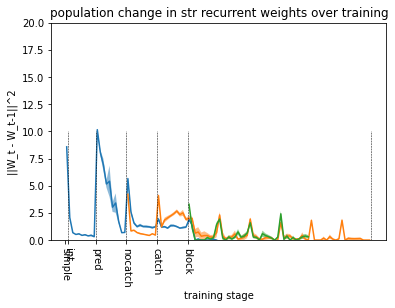

In [37]:
lmax = predlist_str_padded.shape[1]
lmax_nok_nocl = predlist_str_padded_nok_nocl.shape[1]
lmax_nok_cl = predlist_str_padded_nok_cl.shape[1]



nm = [1, 9, 10, 10, 10, 60]
#nm0 = [0, 1, 10, 10, 10, 10]
nm0 = [0, 1, 9, 10, 10, 10]
#lmax = sum(nm)
clstart = sum(nm[0:2])
noclstart = sum(nm[0:3])


diffmean = np.nanmean(predlist_str_padded, axis=0)
print(diffmean.shape)
diffsem = np.nanstd(predlist_str_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_str_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_str_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_str_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_str_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm0)-0.5, labels = [stagedict[k] for k in range(len(nm0))], rotation = -90)
#plt.title('population change in prediction head weights over training')
#plt.title('population change in memory head weights over training')
#plt.title('population change in ofc recurrent weights over training')
plt.title('population change in str recurrent weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
#plt.xlim([0,28])
plt.ylim([0,20])

    
plt.savefig(savedir+'str_weights_allcl.pdf')
plt.show()

/state/partition1/job-37384821/ipykernel_1793229/2441901259.py:1: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_ofc_padded, axis=0)
/ext3/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/state/partition1/job-37384821/ipykernel_1793229/2441901259.py:4: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_ofc_padded_nok_cl, axis=0)
/state/partition1/job-37384821/ipykernel_1793229/2441901259.py:7: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_ofc_padded_nok_nocl, axis=0)


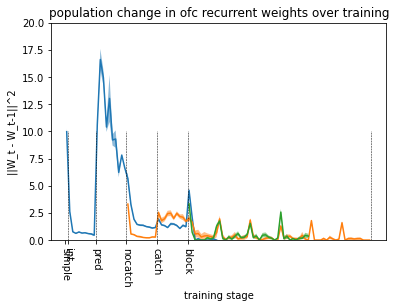

In [38]:
diffmean = np.nanmean(predlist_ofc_padded, axis=0)
diffsem = np.nanstd(predlist_ofc_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_ofc_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_ofc_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_ofc_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_ofc_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm0)-0.5, labels = [stagedict[k] for k in range(len(nm0))], rotation = -90)
#plt.title('population change in prediction head weights over training')
#plt.title('population change in memory head weights over training')
#plt.title('population change in ofc recurrent weights over training')
plt.title('population change in ofc recurrent weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
#plt.xlim([0,28])
plt.ylim([0,20])

    
#plt.savefig(savedir+'ofc_weights_allcl.pdf')
plt.show()

In [23]:
savedir

'/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/full_cl/figs/'